In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib
data_root_orig="/home/yee/DataSet/flower_photos"
data_root = pathlib.Path(data_root_orig)
for item in data_root.iterdir():
    print(item)

/home/yee/DataSet/flower_photos/LICENSE.txt
/home/yee/DataSet/flower_photos/roses
/home/yee/DataSet/flower_photos/sunflowers
/home/yee/DataSet/flower_photos/dandelion
/home/yee/DataSet/flower_photos/tulips
/home/yee/DataSet/flower_photos/daisy


In [3]:
import random
#获取所有图片的路径
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
#将所有路径打乱
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

3670

In [4]:
all_image_paths[:3]

['/home/yee/DataSet/flower_photos/roses/5332550500_ab341aefd8.jpg',
 '/home/yee/DataSet/flower_photos/dandelion/3533075436_0954145b9f_m.jpg',
 '/home/yee/DataSet/flower_photos/daisy/8938566373_d129e7af75.jpg']

In [5]:
from PIL import Image
import os
train_images = []
for image in all_image_paths:
    #print((os.path.join(image)))
    train_images.append(Image.open(os.path.join(image)))

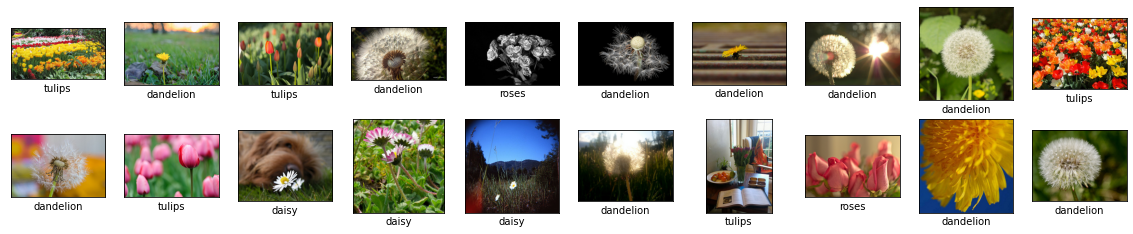

In [22]:
import matplotlib.pyplot as plt

train_labels  = [pathlib.Path(path).parent.name for path in all_image_paths]

plt.figure(figsize=(20,10))
for i in range(20):
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(train_labels[i])
plt.show()

In [6]:
img_height=180
img_width=180

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_root,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(180, 180),
  batch_size=32)

class_names = train_ds.class_names
print("\n",class_names)

train_ds

Found 3670 files belonging to 5 classes.
Using 2936 files for training.

 ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_root,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(180, 180),
  batch_size=32)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


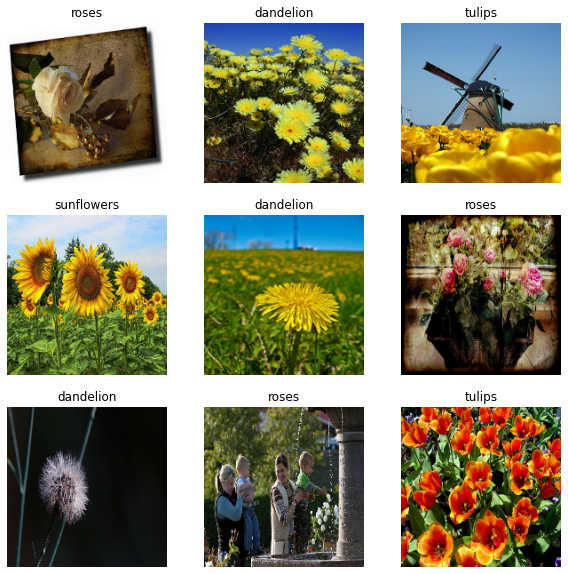

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.8430284


In [9]:
num_classes = 5

In [19]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 22, 64)       

In [30]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 31s 330ms/step - loss: 1.5763 - accuracy: 0.3436 - val_loss: 1.0745 - val_accuracy: 0.5586
Epoch 2/10
92/92 [==============================] - 27s 299ms/step - loss: 1.0164 - accuracy: 0.6013 - val_loss: 1.0177 - val_accuracy: 0.5913
Epoch 3/10
92/92 [==============================] - 28s 300ms/step - loss: 0.7798 - accuracy: 0.7167 - val_loss: 0.9257 - val_accuracy: 0.6376
Epoch 4/10
92/92 [==============================] - 28s 300ms/step - loss: 0.5707 - accuracy: 0.7993 - val_loss: 0.9948 - val_accuracy: 0.6471
Epoch 5/10
92/92 [==============================] - 29s 315ms/step - loss: 0.4159 - accuracy: 0.8644 - val_loss: 1.0758 - val_accuracy: 0.6553
Epoch 6/10
92/92 [==============================] - 29s 310ms/step - loss: 0.2481 - accuracy: 0.9188 - val_loss: 1.3721 - val_accuracy: 0.6471
Epoch 7/10
92/92 [==============================] - 28s 300ms/step - loss: 0.1364 - accuracy: 0.9666 - val_loss: 1.4351 - val_accuracy: 0.6158

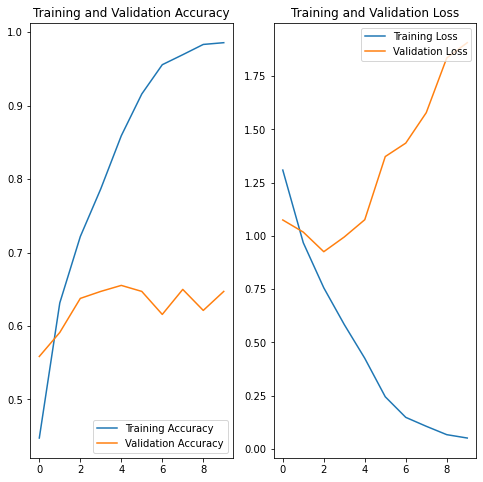

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [10]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

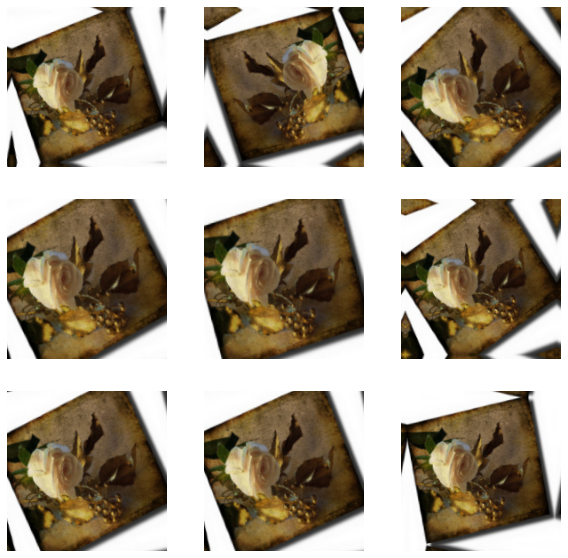

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [13]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [11]:
def create_model():
    model = Sequential([
      data_augmentation,
      layers.experimental.preprocessing.Rescaling(1./255),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(0.2),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(num_classes)
    ])
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return model

In [26]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)       

In [27]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 30s 319ms/step - loss: 1.3242 - accuracy: 0.4463 - val_loss: 1.0871 - val_accuracy: 0.5409
Epoch 2/15
92/92 [==============================] - 28s 310ms/step - loss: 0.9851 - accuracy: 0.6010 - val_loss: 0.9328 - val_accuracy: 0.6294
Epoch 3/15
92/92 [==============================] - 29s 315ms/step - loss: 0.8756 - accuracy: 0.6600 - val_loss: 0.9764 - val_accuracy: 0.6022
Epoch 4/15
92/92 [==============================] - 29s 313ms/step - loss: 0.8761 - accuracy: 0.6620 - val_loss: 0.9300 - val_accuracy: 0.6390
Epoch 5/15
92/92 [==============================] - 29s 317ms/step - loss: 0.8011 - accuracy: 0.6882 - val_loss: 0.7936 - val_accuracy: 0.6757
Epoch 6/15
92/92 [==============================] - 29s 313ms/step - loss: 0.7769 - accuracy: 0.6943 - val_loss: 0.7680 - val_accuracy: 0.6907
Epoch 7/15
92/92 [==============================] - 29s 314ms/step - loss: 0.7270 - accuracy: 0.7220 - val_loss: 0.7255 - val_accuracy: 0.7180

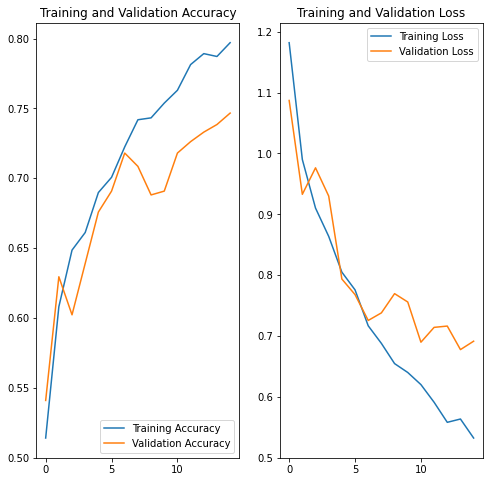

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
# 保存权重
model.save_weights('./checkpoints/my_checkpoint')

# 创建模型实例
model = create_model()

# 恢复权重
model.load_weights('./checkpoints/my_checkpoint')

# 评估模型
#loss,acc = model.evaluate(test_images,  test_labels, verbose=2)
#print("Restored model, accuracy: {:5.2f}%".format(100*acc))

sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to daisy with a 21.68 percent confidence.


In [17]:
#data_root_orig="/home/yee/DataSet/flower_photos/sunflowers"
data_root_orig="/home/yee/GraduationDesign/MakeSampleSet/sunflowers"
data_root = pathlib.Path(data_root_orig)
# 创建模型实例
model = create_model()

# 恢复权重
model.load_weights('./checkpoints/my_checkpoint')
for item in data_root.iterdir():
    #print(item)
    img = keras.preprocessing.image.load_img(
        item, target_size=(img_height, img_width)
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "Likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

Likely belongs to roses with a 21.21 percent confidence.
Likely belongs to daisy with a 20.49 percent confidence.
Likely belongs to tulips with a 21.05 percent confidence.
Likely belongs to tulips with a 21.62 percent confidence.
Likely belongs to tulips with a 21.72 percent confidence.
Likely belongs to tulips with a 20.91 percent confidence.
Likely belongs to tulips with a 21.76 percent confidence.
Likely belongs to roses with a 21.97 percent confidence.
Likely belongs to roses with a 21.50 percent confidence.
Likely belongs to tulips with a 20.73 percent confidence.
Likely belongs to sunflowers with a 21.52 percent confidence.
Likely belongs to roses with a 20.91 percent confidence.
Likely belongs to tulips with a 22.37 percent confidence.
Likely belongs to tulips with a 21.77 percent confidence.
Likely belongs to roses with a 22.06 percent confidence.
Likely belongs to roses with a 20.98 percent confidence.
Likely belongs to tulips with a 20.92 percent confidence.
Likely belongs to

/home/yee/.pyenv/versions/3.7.3/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Likely belongs to roses with a 20.87 percent confidence.
Likely belongs to roses with a 21.99 percent confidence.
Likely belongs to roses with a 22.10 percent confidence.
Likely belongs to roses with a 20.97 percent confidence.
Likely belongs to roses with a 21.20 percent confidence.
Likely belongs to roses with a 21.38 percent confidence.
Likely belongs to tulips with a 21.76 percent confidence.
Likely belongs to tulips with a 20.87 percent confidence.
Likely belongs to tulips with a 20.42 percent confidence.
Likely belongs to roses with a 21.03 percent confidence.
Likely belongs to roses with a 21.09 percent confidence.
Likely belongs to roses with a 21.79 percent confidence.
Likely belongs to tulips with a 21.49 percent confidence.
Likely belongs to tulips with a 20.72 percent confidence.
Likely belongs to tulips with a 20.77 percent confidence.
Likely belongs to dandelion with a 21.04 percent confidence.
Likely belongs to roses with a 21.21 percent confidence.
Likely belongs to ros